In [361]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import exp

# set display options
pd.set_option('display.max_columns', None)

In [362]:
#import dataset
X_train = pd.read_pickle('./data/X_train.pkl')
y_train = pd.read_pickle('./data/y_train.pkl')

X_test = pd.read_pickle('./data/X_test.pkl')
y_test = pd.read_pickle('./data/y_test.pkl')


In [363]:
X_train.head()

,Season,AGIncome,TotIncome,SalariesWages,NumUnemply,TotTaxes,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,total_pop,median_age,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,income_per_capita,vacant_housing_units_for_rent,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,population_change,natural_amenity_rank
0,2.0,1.222721e+06,1.247542e+06,7.633333e+05,208.333333,138435.833333,4.1,0.8,0.7,94382.0,41.7,0.540569,0.090324,0.097815,0.240713,0.5942,68995.0,0.044332,29.4,0.063561,0.027569,0.227130,0.176167,3.516101,3.0
1,2.0,8.573410e+05,8.710963e+05,6.170520e+05,161.666667,46717.166667,5.1,2.2,1.9,70103.0,31.2,0.810379,0.028273,0.065603,0.067843,0.4959,69983.0,0.050289,25.5,0.032352,0.026803,0.367145,0.168951,2.035550,3.0
2,2.0,2.270603e+06,2.299776e+06,1.031574e+06,145.000000,303624.166667,4.1,0.8,0.7,61514.0,42.6,0.720308,0.033488,0.108479,0.109406,0.5630,114641.0,0.053383,23.9,0.047436,0.017541,0.257990,0.245017,1.228203,3.0
3,2.0,1.021157e+06,1.032314e+06,8.244232e+05,300.000000,51148.166667,4.6,0.0,0.0,105854.0,34.8,0.511828,0.071570,0.180296,0.210082,0.3699,48249.0,0.057867,26.5,0.051911,0.042341,0.223761,0.111106,0.922800,3.0
4,2.0,1.021157e+06,1.032314e+06,8.244232e+05,300.000000,51148.166667,5.1,3.5,1.7,105854.0,34.8,0.511828,0.071570,0.180296,0.210082,0.3699,48249.0,0.057867,26.5,0.051911,0.042341,0.223761,0.111106,0.922800,3.0


In [364]:
X_train.describe()

,Season,AGIncome,TotIncome,SalariesWages,NumUnemply,TotTaxes,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,total_pop,median_age,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,income_per_capita,vacant_housing_units_for_rent,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,population_change,natural_amenity_rank
count,21340.000000,2.134000e+04,2.134000e+04,2.134000e+04,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000
mean,2.255436,2.218206e+05,2.248002e+05,1.499131e+05,81.617229,13481.874235,3.552962,1.227835,0.784836,34109.383739,30.330872,0.422556,0.133056,0.074215,0.182392,0.389374,30837.033505,0.049118,26.267901,0.103805,0.041846,0.141672,0.066564,1.613954,3.530787
std,1.017689,2.323025e+05,2.353501e+05,1.327397e+05,77.853060,25100.731445,1.760512,1.093314,0.756351,23194.022087,13.987674,0.294448,0.186900,0.100126,0.201897,0.175830,21632.957022,0.040625,12.270446,0.066214,0.024899,0.097216,0.054464,5.215938,2.127819
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.924590,0.000000
25%,2.000000,8.924967e+04,9.023417e+04,6.850967e+04,28.333333,2226.666667,3.000000,0.000000,0.000000,18799.000000,30.600000,0.119583,0.013951,0.011158,0.039689,0.397900,18999.000000,0.021829,25.800000,0.056514,0.027347,0.070500,0.024602,-0.018588,3.000000
50%,2.000000,1.728065e+05,1.747173e+05,1.288958e+05,61.666667,6848.833333,4.000000,1.300000,0.700000,33654.000000,34.700000,0.462422,0.059799,0.039493,0.109406,0.445000,28641.000000,0.044316,29.400000,0.108242,0.043817,0.136406,0.056098,0.195323,3.000000
75%,3.000000,2.892583e+05,2.940407e+05,2.039092e+05,116.666667,15954.666667,4.700000,2.000000,1.300000,48312.000000,38.200000,0.673119,0.166066,0.094962,0.251130,0.487600,41786.000000,0.069310,33.400000,0.152719,0.058021,0.213302,0.099588,1.046780,5.000000
max,4.000000,2.383970e+06,2.406416e+06,1.031574e+06,815.000000,321766.000000,9.200000,6.400000,3.400000,114647.000000,67.400000,0.973506,0.982393,0.726602,0.977026,0.685700,154723.000000,0.487710,50.000000,0.279457,0.126473,0.462318,0.344235,67.122977,7.000000


In [365]:
X_train['AGIncome'] = (X_train['AGIncome']/1000)*X_train['total_pop']
X_train['TotIncome'] = (X_train['TotIncome']/1000)*X_train['total_pop']
X_train['SalariesWages'] = (X_train['SalariesWages']/1000)*X_train['total_pop']
X_train['NumUnemply'] =(X_train['NumUnemply']/1000)*X_train['total_pop']
X_train['TotTaxes'] = (X_train['TotTaxes']/1000)*X_train['total_pop']


In [366]:
X_train.head()

,Season,AGIncome,TotIncome,SalariesWages,NumUnemply,TotTaxes,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,total_pop,median_age,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,income_per_capita,vacant_housing_units_for_rent,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,population_change,natural_amenity_rank
0,2.0,1.154029e+08,1.177456e+08,7.204493e+07,19662.916667,1.306585e+07,4.1,0.8,0.7,94382.0,41.7,0.540569,0.090324,0.097815,0.240713,0.5942,68995.0,0.044332,29.4,0.063561,0.027569,0.227130,0.176167,3.516101,3.0
1,2.0,6.010218e+07,6.106647e+07,4.325720e+07,11333.318333,3.275014e+06,5.1,2.2,1.9,70103.0,31.2,0.810379,0.028273,0.065603,0.067843,0.4959,69983.0,0.050289,25.5,0.032352,0.026803,0.367145,0.168951,2.035550,3.0
2,2.0,1.396739e+08,1.414684e+08,6.345621e+07,8919.530000,1.867714e+07,4.1,0.8,0.7,61514.0,42.6,0.720308,0.033488,0.108479,0.109406,0.5630,114641.0,0.053383,23.9,0.047436,0.017541,0.257990,0.245017,1.228203,3.0
3,2.0,1.080936e+08,1.092746e+08,8.726849e+07,31756.200000,5.414238e+06,4.6,0.0,0.0,105854.0,34.8,0.511828,0.071570,0.180296,0.210082,0.3699,48249.0,0.057867,26.5,0.051911,0.042341,0.223761,0.111106,0.922800,3.0
4,2.0,1.080936e+08,1.092746e+08,8.726849e+07,31756.200000,5.414238e+06,5.1,3.5,1.7,105854.0,34.8,0.511828,0.071570,0.180296,0.210082,0.3699,48249.0,0.057867,26.5,0.051911,0.042341,0.223761,0.111106,0.922800,3.0


In [367]:
X_train.describe()

,Season,AGIncome,TotIncome,SalariesWages,NumUnemply,TotTaxes,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,total_pop,median_age,white_pop,black_pop,asian_pop,hispanic_pop,gini_index,income_per_capita,vacant_housing_units_for_rent,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,population_change,natural_amenity_rank
count,21340.000000,2.134000e+04,2.134000e+04,2.134000e+04,21340.000000,2.134000e+04,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000,21340.000000
mean,2.255436,1.004645e+07,1.017681e+07,7.057871e+06,4097.911833,6.038436e+05,3.552962,1.227835,0.784836,34109.383739,30.330872,0.422556,0.133056,0.074215,0.182392,0.389374,30837.033505,0.049118,26.267901,0.103805,0.041846,0.141672,0.066564,1.613954,3.530787
std,1.017689,1.347399e+07,1.364503e+07,9.044445e+06,5697.656952,1.290531e+06,1.760512,1.093314,0.756351,23194.022087,13.987674,0.294448,0.186900,0.100126,0.201897,0.175830,21632.957022,0.040625,12.270446,0.066214,0.024899,0.097216,0.054464,5.215938,2.127819
min,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.924590,0.000000
25%,2.000000,2.029716e+06,2.042872e+06,1.473903e+06,595.723333,6.363813e+04,3.000000,0.000000,0.000000,18799.000000,30.600000,0.119583,0.013951,0.011158,0.039689,0.397900,18999.000000,0.021829,25.800000,0.056514,0.027347,0.070500,0.024602,-0.018588,3.000000
50%,2.000000,6.334028e+06,6.425203e+06,4.488561e+06,2228.395000,2.349541e+05,4.000000,1.300000,0.700000,33654.000000,34.700000,0.462422,0.059799,0.039493,0.109406,0.445000,28641.000000,0.044316,29.400000,0.108242,0.043817,0.136406,0.056098,0.195323,3.000000
75%,3.000000,1.284321e+07,1.296186e+07,8.951370e+06,5075.198333,6.712372e+05,4.700000,2.000000,1.300000,48312.000000,38.200000,0.673119,0.166066,0.094962,0.251130,0.487600,41786.000000,0.069310,33.400000,0.152719,0.058021,0.213302,0.099588,1.046780,5.000000
max,4.000000,1.396739e+08,1.414684e+08,8.726849e+07,58472.540000,1.867714e+07,9.200000,6.400000,3.400000,114647.000000,67.400000,0.973506,0.982393,0.726602,0.977026,0.685700,154723.000000,0.487710,50.000000,0.279457,0.126473,0.462318,0.344235,67.122977,7.000000


In [368]:
len(X_train[X_train.AGIncome == 0])

3376

In [369]:
#show columns with missing values
X_train.columns[X_train.isnull().any()]


Index([], dtype='object')

In [370]:
X_train = X_train.replace(np.nan, 0)


In [371]:
#show columns with missing values
X_train.columns[X_train.isnull().any()]


Index([], dtype='object')

In [372]:
X_train.columns

Index(['Season', 'AGIncome', 'TotIncome', 'SalariesWages', 'NumUnemply',
       'TotTaxes', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89',
       'MortDeliq90', 'total_pop', 'median_age', 'white_pop', 'black_pop',
       'asian_pop', 'hispanic_pop', 'gini_index', 'income_per_capita',
       'vacant_housing_units_for_rent', 'percent_income_spent_on_rent',
       'high_school_diploma', 'associates_degree', 'bachelors_degree',
       'masters_degree', 'population_change', 'natural_amenity_rank'],
      dtype='object')

In [373]:
X_train.drop(columns = ['total_pop'], inplace=True)


In [374]:
X_test = X_test.apply(pd.to_numeric)

In [375]:
X_test['AGIncome'] = (X_test['AGIncome']/1000)*X_test['total_pop']
X_test['TotIncome'] = (X_test['TotIncome']/1000)*X_test['total_pop']
X_test['SalariesWages'] = (X_test['SalariesWages']/1000)*X_test['total_pop']
X_test['NumUnemply'] = (X_test['NumUnemply']/1000)*X_test['total_pop']
X_test['TotTaxes'] = (X_test['TotTaxes']/1000)*X_test['total_pop']

In [376]:
X_test = X_test.replace(np.nan, 0)

In [377]:
X_test.columns[X_test.isnull().any()]

Index([], dtype='object')

In [378]:
y_test = y_test.replace(np.nan, 0)

In [379]:
X_train.shape

(21340, 24)

In [380]:
y_train.shape

(21340,)

In [381]:
X_test.shape

(21597, 25)

In [382]:
# X_train['AGIncome'] = X_train['AGIncome']*1000
# X_train['TotIncome'] = X_train['TotIncome']*1000
# X_train['SalariesWages'] = X_train['SalariesWages']*1000
# X_train['NumUnemply'] = X_train['NumUnemply']*1000
# X_train['TotTaxes'] = X_train['TotTaxes']*1000

In [383]:
X_test.drop(columns = ['total_pop'], inplace=True)

In [384]:
X_test.columns

Index(['Season', 'AGIncome', 'TotIncome', 'SalariesWages', 'NumUnemply',
       'TotTaxes', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89',
       'MortDeliq90', 'median_age', 'white_pop', 'black_pop', 'asian_pop',
       'hispanic_pop', 'gini_index', 'income_per_capita',
       'vacant_housing_units_for_rent', 'percent_income_spent_on_rent',
       'high_school_diploma', 'associates_degree', 'bachelors_degree',
       'masters_degree', 'population_change', 'natural_amenity_rank'],
      dtype='object')

In [385]:
#feature selection
model_cols = ['Season', 'AGIncome', 'TotIncome', 'SalariesWages', 'NumUnemply',\
              'TotTaxes', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89','MortDeliq90']

X_train = X_train[model_cols]

X_test = X_test[model_cols]

## Model Generation

In [386]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import model_selection

In [387]:
lm = LinearRegression()

lm.fit(X_train, y_train)

print("Train Score: %.4f" % lm.score(X_train, y_train))
print("Test Score:  %.4f" % lm.score(X_test, y_test))

print(lm.score(X_train, y_train)- lm.score(X_test, y_test))



Train Score: 0.0017
Test Score:  -0.0041
0.0057933545396989805


In [358]:
lm.intercept_, lm.coef_

(1602.484524428602,
 array([ 1.95373540e-04,  1.17131798e+00, -4.63957117e+01, -6.60685638e+01,
         1.06995716e+02, -6.22585422e+01, -1.00415408e+00, -6.60818703e+00,
         2.08309092e+01,  1.53544850e-01, -1.14103128e+02, -2.32730528e+02,
         1.98074508e+02, -6.37937906e+02]))

In [359]:
from sklearn.model_selection import cross_val_score
print(np.sqrt(-1* cross_val_score(lm, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs =-1)))

[632.82746341 630.42792002 630.81360758 635.68340987 632.56349803]


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

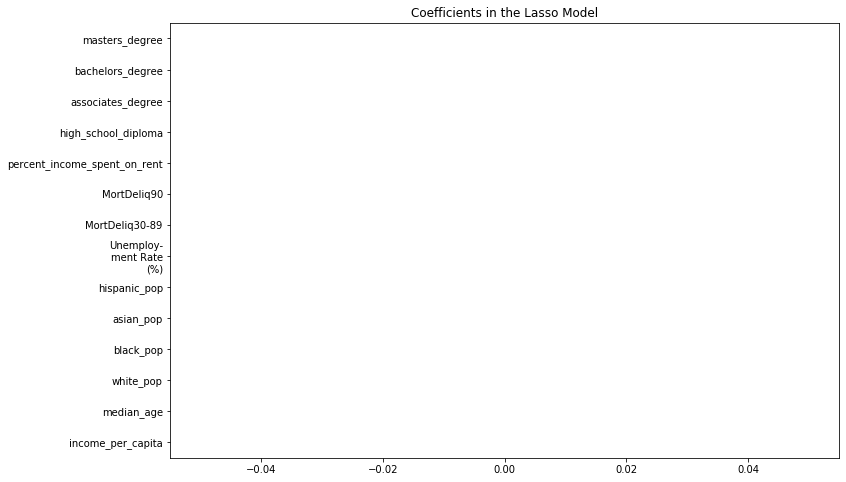

In [360]:
# param_grid={'alpha': np.logspace(-5, -3, 100)}
# grid_search = model_selection.GridSearchCV(estimator = Lasso(), param_grid = param_grid, cv=3)
# grid_search.fit(X_train, y_train)

# print("Cross Validation")
# print("-" * 20)
# print("Best parameter: ", grid_search.best_params_)
# print("Best CV score:  %.4f" % grid_search.best_score_)

#alpha_cv = grid_search.best_estimator_.get_params()['alpha']

lasso = Lasso(alpha = .1, normalize=True).fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values()])
imp_coef.plot(kind = "barh", figsize = (12, 8))
plt.title("Coefficients in the Lasso Model")

In [195]:
lm.fit(X_train, y_train)

print('Linear Model')
print('-'*20)
print("Train Score:   %.5f" % lm.score(X_train, y_train))
print("Test Score:    %.5f\n" % lm.score(X_test, y_test))

Linear Model
--------------------
Train Score:   0.55037
Test Score:    -7.62767



In [194]:
lasso.fit(X_train, y_train)

print('Penalized Linear Model')
print('-'*20)
print("Train Score: %.5f" % lasso.score(X_train, y_train))
print("Test Score:  %.5f" % lasso.score(X_test, y_test))

Penalized Linear Model
--------------------
Train Score: 0.49512
Test Score:  0.09001


In [209]:
from sklearn.metrics import mean_squared_error

def expo(list_):
    return list(map(exp, list_))

print('Final Model')
print('-'*20)
lm.fit(X_train, y_train)

y_pred = lin_mod.predict(X_test)

    
print("R^2 Score:  %.2f" % (100*lm.score(X_train, y_train)))
print("Mean Error: $%.0f\n" % mean_squared_error(y_test, y_pred))


Final Model
--------------------
R^2 Score:  55.04
Mean Error: $2805450



In [207]:
# Instantiate, fit, predict
from sklearn.metrics import r2_score 

lin_mod = LinearRegression()
lin_mod.fit(X_train, y_train)
y_pred = lin_mod.predict(X_test)

# Coefficient estimates
print('Coefficients: \n', lin_mod.coef_)

# Mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))

# Explained variance score
print('R_squared score: %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [ 1.96741014e-02 -3.20304751e+04 -2.68633429e+03 -2.65273608e+03
 -8.97398061e+02 -1.51653929e+03 -5.82863577e+00 -1.56636450e+02
  2.56840403e+02  3.38074149e+01  2.43390371e+03 -2.45858811e+02
  9.09062869e+02  2.74018017e+03]
Mean squared error: 2805449.53
R_squared score: -7.63


In [208]:
res_x = [target/1000 for target in expo(y_test)]
res_y = [(target - predict)/1000 for (target, predict) in zip(expo(y_test), expo(lm.predict(y_pred)))]
plt.figure(figsize=(8,8))
plt.scatter(res_x, res_y, alpha = 0.5)
plt.title('Distribution of Residuals')
plt.xlabel('Actual House Price in $K')
plt.ylabel('Residual House Price in $K')

OverflowError: math range error

In [ ]:
#feature engineering

#Median_age of each zipcode



In [22]:
X_train.columns

Index(['SizeRank', 'Season', 'AGIncome', 'TotIncome', 'SalariesWages',
       'NumUnemply', 'TotTaxes', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89',
       'MortDeliq90', 'RentalVacancyRate', 'white', 'black', 'asian', 'NHOPI',
       'hispanic_latino', '20_to_24', '25_to_34', '35_to_44', '45_to_54',
       '55_to_59', '60_to_64', '65_to_74', '75_to_85', '85_over',
       'Population'],
      dtype='object')

In [ ]:
#drop 'SizeRank',

#1 # keep ordinal'Season'

# drop 'AGIncome', 'TotIncome', 'SalariesWages', Unemploy-\nment Rate\n(%)', 

#2 #Keep'TotTaxes', 

#3 #''NumUnemply', 

#4 #'MortDeliq30-89',

#5 #'MortDeliq90', 

#6 #'RentalVacancyRate', 

#7-9 'white', 'black', 'asian', 'NHOPI',
       
# drop for now'hispanic_latino', 

#10 # Feature engineer to be median age '20_to_24', '25_to_34', '35_to_44', '45_to_54','55_to_59', '60_to_64', '65_to_74', '75_to_85', '85_over',

# drop'Population'

In [141]:
train_set = pd.concat([X_train, y_train], axis=1)

In [142]:
train_set.head()

,income_per_capita,median_age,white_pop,black_pop,asian_pop,hispanic_pop,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,value
0,68995.0,0.000442,0.540569,0.090324,0.097815,0.240713,4.1,0.8,0.7,29.4,0.063561,0.027569,0.227130,0.176167,3727.0
1,69983.0,0.000445,0.810379,0.028273,0.065603,0.067843,4.5,0.0,0.0,25.5,0.032352,0.026803,0.367145,0.168951,1735.0
2,69983.0,0.000445,0.810379,0.028273,0.065603,0.067843,5.1,2.2,1.9,25.5,0.032352,0.026803,0.367145,0.168951,1735.0
3,69983.0,0.000445,0.810379,0.028273,0.065603,0.067843,3.8,0.0,0.0,25.5,0.032352,0.026803,0.367145,0.168951,1735.0
4,114641.0,0.000693,0.720308,0.033488,0.108479,0.109406,4.1,0.8,0.7,23.9,0.047436,0.017541,0.257990,0.245017,3609.0


In [147]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
print ("OLS regression model for the association between ZRI value and asian_pop")
# reg1 is the model name , followed by equal sign. 
reg1 = smf.ols(formula = 'value ~ asian_pop', data=train_set).fit()
# print the result
print (reg1.summary())

OLS regression model for the association between ZRI value and asian_pop
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                 1.523e+04
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:43:48   Log-Likelihood:            -4.1841e+05
No. Observations:               54620   AIC:                         8.368e+05
Df Residuals:                   54618   BIC:                         8.368e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [148]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
print ("OLS regression model for the association between ZRI value and income_per_capita")
# reg1 is the model name , followed by equal sign. 
reg1 = smf.ols(formula = 'value ~ income_per_capita', data=train_set).fit()
# print the result
print (reg1.summary())

OLS regression model for the association between ZRI value and income_per_capita
                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                 1.891e+04
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        11:44:04   Log-Likelihood:            -4.1701e+05
No. Observations:               54620   AIC:                         8.340e+05
Df Residuals:                   54618   BIC:                         8.340e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

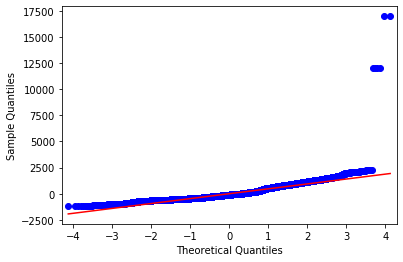

In [149]:
#Q-Q plot for normality
fig4=sm.qqplot(reg1.resid, line='r')

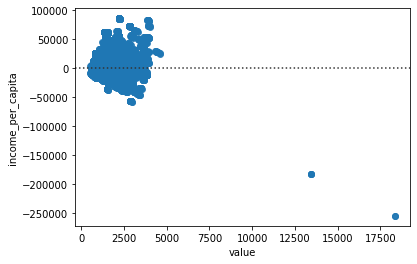

In [151]:
# simple plot of residuals
import seaborn as sns

sns.residplot('value', 'income_per_capita', data=train_set)

In [159]:
train_set.columns

Index(['income_per_capita', 'median_age', 'white_pop', 'black_pop',
       'asian_pop', 'hispanic_pop', 'Unemploy-\nment Rate\n(%)',
       'MortDeliq30-89', 'MortDeliq90', 'percent_income_spent_on_rent',
       'high_school_diploma', 'associates_degree', 'bachelors_degree',
       'masters_degree', 'value'],
      dtype='object')

In [176]:
print ("\n\n---------------------")
print ("TRAIN SET INFORMATION")
print ("---------------------")
print ("Shape of training set:", train_set.shape, "\n")
print ("Column Headers:", list(train_set.columns.values), "\n")
print (train_set.dtypes)



---------------------
TRAIN SET INFORMATION
---------------------
Shape of training set: (54620, 15) 

Column Headers: ['income_per_capita', 'median_age', 'white_pop', 'black_pop', 'asian_pop', 'hispanic_pop', 'Unemploy-\nment Rate\n(%)', 'MortDeliq30-89', 'MortDeliq90', 'percent_income_spent_on_rent', 'high_school_diploma', 'associates_degree', 'bachelors_degree', 'masters_degree', 'value'] 

income_per_capita               float64
median_age                      float64
white_pop                       float64
black_pop                       float64
asian_pop                       float64
hispanic_pop                    float64
Unemploy-\nment Rate\n(%)       float64
MortDeliq30-89                  float64
MortDeliq90                     float64
percent_income_spent_on_rent    float64
high_school_diploma             float64
associates_degree               float64
bachelors_degree                float64
masters_degree                  float64
value                           float64
d

In [177]:
import re
missing_values = []
nonumeric_values = []

print ("TRAINING SET INFORMATION")
print ("========================\n")

for column in train_set:
    # Find all the unique feature values
    uniq = train_set[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 10):
        print("~~Listing up to 10 unique values~~")
    print (uniq[0:10])
    print ("\n-----------------------------------------------------------------------\n")
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(train_set[column]).sum())
        missing_values.append(s)
    
    # Find features with non-numeric values
    for i in range (1, np.prod(uniq.shape)):
        if (re.match('nan', str(uniq[i]))):
            break
        if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
            nonumeric_values.append(column)
            break
  
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print ("Features with missing values:\n{}\n\n" .format(missing_values))
print ("Features with non-numeric values:\n{}" .format(nonumeric_values))
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

TRAINING SET INFORMATION

'income_per_capita' has 1608 unique values
~~Listing up to 10 unique values~~
[ 68995.  69983. 114641.  48249.  73991.  30677.  26893.  22610.  39257.
  24798.]

-----------------------------------------------------------------------

'median_age' has 1640 unique values
~~Listing up to 10 unique values~~
[0.00044182 0.00044506 0.00069253 0.00032875 0.00043005 0.00053641
 0.00031554 0.00027878 0.00054792 0.00033241]

-----------------------------------------------------------------------

'white_pop' has 1640 unique values
~~Listing up to 10 unique values~~
[0.54056918 0.81037901 0.72030757 0.51182761 0.79384834 0.20799487
 0.29420933 0.09150449 0.55763427 0.11041575]

-----------------------------------------------------------------------

'black_pop' has 1639 unique values
~~Listing up to 10 unique values~~
[0.09032443 0.02827268 0.03348831 0.07157028 0.04209327 0.06111004
 0.15225373 0.02380314 0.17136453 0.65292197]

----------------------------------------

In [178]:
# Check for duplicate index or rows
idsUnique = len(set(train_set.index))
idsTotal = train_set.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

There are 0 duplicate IDs for 54620 total entries


In [179]:
#get summary of numerical variables
train_set.describe()

,income_per_capita,median_age,white_pop,black_pop,asian_pop,hispanic_pop,Unemploy-\nment Rate\n(%),MortDeliq30-89,MortDeliq90,percent_income_spent_on_rent,high_school_diploma,associates_degree,bachelors_degree,masters_degree,value
count,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000,54620.000000
mean,35310.429696,0.001272,0.549537,0.149582,0.073754,0.190990,4.401668,0.584074,0.378962,30.853182,0.129229,0.049854,0.160802,0.075925,1451.298792
std,16932.269793,0.001101,0.241982,0.184604,0.087030,0.182757,1.410166,0.966769,0.655935,4.856297,0.053856,0.018496,0.079110,0.048576,580.814489
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,541.000000
25%,23420.500000,0.000735,0.382418,0.027370,0.020537,0.061989,3.600000,0.000000,0.000000,27.500000,0.087329,0.036387,0.098236,0.039104,1035.750000
50%,31472.000000,0.001043,0.589044,0.079101,0.042825,0.128981,4.200000,0.000000,0.000000,30.300000,0.131911,0.048876,0.154487,0.066141,1335.000000
75%,43521.500000,0.001505,0.745745,0.189452,0.096552,0.245951,5.000000,1.200000,0.700000,33.500000,0.169399,0.061854,0.213617,0.107515,1724.000000
max,154723.000000,0.015890,0.973506,0.982393,0.726602,0.977026,14.600000,6.400000,3.600000,50.000000,0.279457,0.126473,0.462318,0.344235,18349.000000


In [180]:
# Skewness of the distribution

print(train_set.skew())

# Values close to 0 show less skew


income_per_capita               1.612365
median_age                      7.017474
white_pop                      -0.499358
black_pop                       2.174977
asian_pop                       2.658967
hispanic_pop                    1.646705
Unemploy-\nment Rate\n(%)       1.013576
MortDeliq30-89                  1.607193
MortDeliq90                     1.717386
percent_income_spent_on_rent    0.588533
high_school_diploma             0.047329
associates_degree               0.442241
bachelors_degree                0.520415
masters_degree                  0.875553
value                           2.476307
dtype: float64


In [181]:
# Skewness of the distribution

print(train_set.kurt())

income_per_capita                4.086358
median_age                      73.662056
white_pop                       -0.711771
black_pop                        5.017894
asian_pop                        8.898027
hispanic_pop                     2.494149
Unemploy-\nment Rate\n(%)        5.123888
MortDeliq30-89                   2.146365
MortDeliq90                      2.085096
percent_income_spent_on_rent     2.098374
high_school_diploma             -0.765055
associates_degree                0.230890
bachelors_degree                -0.133190
masters_degree                   0.454484
value                           40.194009
dtype: float64


In [183]:
#Check when a value in a cloumn is zero
train_set[(train_set['value'] == 0)].count()

income_per_capita               0
median_age                      0
white_pop                       0
black_pop                       0
asian_pop                       0
hispanic_pop                    0
Unemploy-\nment Rate\n(%)       0
MortDeliq30-89                  0
MortDeliq90                     0
percent_income_spent_on_rent    0
high_school_diploma             0
associates_degree               0
bachelors_degree                0
masters_degree                  0
value                           0
dtype: int64

In [184]:
df = train_set[['income_per_capita','value']]


In [185]:
df.head()


,income_per_capita,value
0,68995.0,3727.0
1,69983.0,1735.0
2,69983.0,1735.0
3,69983.0,1735.0
4,114641.0,3609.0


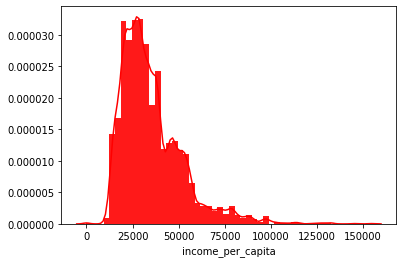

In [187]:
#draw a histogram and not fit a kernel density estimate (KDE).
sns.distplot(df['income_per_capita'], kde = True, color = 'r', hist_kws={'alpha': 0.9})

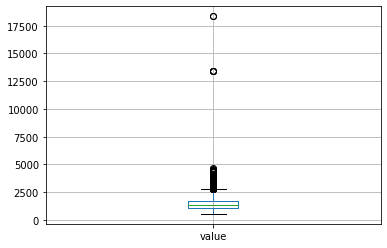

In [189]:
train_set.boxplot(column="value")
#sns.boxplot(x='value', y='Year', data=train_set)

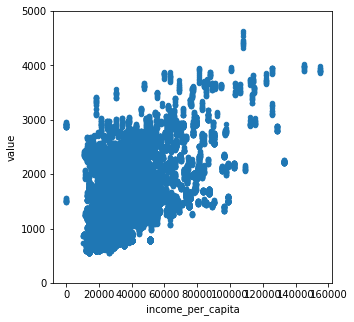

In [193]:
train_set.plot(kind="scatter",     # Create a scatterplot
              x="income_per_capita",          # Put carat on the x axis
              y=np."value",          # Put price on the y axis
              figsize=(5,5),
              ylim=(0,5000))